In [1]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)

import os
import sys
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Local imports
from helpers import download_ml1m_dataset
from utils.ml_to_ncf import preprocess_ml1m_to_ncf_format
from utils.ncfdata import NCFData
from helpers.ncf_model import NCF


In [2]:
dataset = 'ml-1m'
# ============================================================================
# MODEL ARCHITECTURE CONFIGURATION
# ============================================================================

# Choose which model architecture to use
# Options:
#   - 'MLP': Multi-Layer Perceptron only (non-linear interactions)
#   - 'GMF': Generalized Matrix Factorization only (linear interactions)
#   - 'NeuMF-end': Neural Matrix Factorization trained from scratch (end-to-end)
#   - 'NeuMF-pre': Neural Matrix Factorization with pre-trained GMF and MLP models
model_name = 'NeuMF-end'
assert model_name in ['MLP', 'GMF', 'NeuMF-end', 'NeuMF-pre'], \
    f"Model must be 'MLP', 'GMF', 'NeuMF-end', or 'NeuMF-pre', got '{model_name}'"

print(f"✓ Model architecture: {model_name}")

# ============================================================================
# DATA AND MODEL PATHS CONFIGURATION
# ============================================================================

# Data will be downloaded automatically during training
# We'll create a local data directory to store downloaded files

data_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Model saving directory
model_path = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

GMF_model_path = os.path.join(model_path, 'GMF.pth')
MLP_model_path = os.path.join(model_path, 'MLP.pth')
NeuMF_model_path = os.path.join(model_path, 'NeuMF.pth')

print(f"✓ Directories configured")
print(f"  - Data directory: {data_dir} (will be created/used for downloaded data)")
print(f"  - Model save path: {model_path}")

# ============================================================================
# 2.4 TRAINING HYPERPARAMETERS
# ============================================================================

# Learning rate: Controls how big steps the optimizer takes during training
# Too high: training might be unstable or diverge
# Too low: training will be very slow
# Typical range: 0.0001 to 0.01
learning_rate = 0.001

# Dropout rate: Regularization technique to prevent overfitting
# Randomly sets some neurons to zero during training
# Range: 0.0 (no dropout) to 0.9 (very aggressive dropout)
# 0.0 means no dropout (all neurons active)
dropout_rate = 0.1

# Batch size: Number of training examples processed together in one iteration
# Larger batch size: more stable gradients, but requires more memory
# Smaller batch size: less memory, but noisier gradients
# Typical values: 64, 128, 256, 512
batch_size = 256

# Number of training epochs: How many times we'll iterate through the entire dataset
# More epochs: better learning, but risk of overfitting
# Too few epochs: model might not learn enough
epochs = 20

# Top-K for evaluation: When evaluating, we recommend top K items to each user
# We measure if the true item is in the top K recommendations
# Common values: 5, 10, 20
top_k = 10

# Factor number: Dimension of the embedding vectors for users and items
# Larger: more capacity to learn complex patterns, but more parameters
# Smaller: fewer parameters, faster training, but less capacity
# Common values: 8, 16, 32, 64
factor_num = 32

# Number of MLP layers: Depth of the Multi-Layer Perceptron component
# More layers: can learn more complex non-linear patterns
# Fewer layers: simpler model, faster training
# Typical range: 1 to 5 layers
num_layers = 3

# Number of negative samples for training: For each positive (user, item) pair,
# we sample this many negative items (items the user hasn't interacted with)
# More negatives: better learning signal, but slower training
# Fewer negatives: faster training, but potentially weaker learning
# Common values: 1, 4, 8
num_ng = 4

# Number of negative samples for testing: During evaluation, for each test item,
# we also provide this many negative items. The model should rank the true item higher.
# Typically 99 negatives + 1 positive = 100 items total per test case
test_num_ng = 99

# Whether to save the trained model
save_model = True

✓ Model architecture: NeuMF-end
✓ Directories configured
  - Data directory: /Users/abbas/Documents/Codes/thesis/recommender/src/../data (will be created/used for downloaded data)
  - Model save path: /Users/abbas/Documents/Codes/thesis/recommender/src/../models


In [3]:
print("=" * 70)
print("STEP 3.1: Downloading MovieLens 1M Dataset")
print("=" * 70)
ratings_file = download_ml1m_dataset(data_dir)


STEP 3.1: Downloading MovieLens 1M Dataset
✓ Dataset already exists at /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat


In [4]:
train_rating_path, test_rating_path, test_negative_path, user_num, item_num, train_mat = \
    preprocess_ml1m_to_ncf_format(ratings_file, data_dir, test_ratio=0.2, test_negatives=99)


✓ Loaded 1000209 ratings
  - Unique users: 6040
  - Unique movies: 3706

Filtering positive interactions (ratings >= 4)...
✓ 575281 positive interactions (out of 1000209 total)

Remapping user and item IDs to be contiguous...
✓ Remapped to 6038 users and 3533 items

Splitting data (train: 80%, test: 20%)...
✓ Training pairs: 460225
✓ Test pairs: 115056

Saving training data to /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.train.rating...
✓ Saved 460225 training pairs

Creating training interaction matrix...
✓ Training matrix created: 460225 interactions

Generating test negative samples (99 negatives per test case)...
✓ Generated test negative samples: 115056 test cases


In [5]:


def load_all_data(train_rating_path, test_negative_path):    
    # Load training data
    print(f"Loading training data from {train_rating_path}...")
    train_data = pd.read_csv(
        train_rating_path,
        sep='\t',
        header=None,
        names=['user', 'item'],
        usecols=[0, 1],
        dtype={0: np.int32, 1: np.int32}
    )
    
    # Calculate number of users and items
    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1
    
    print(f"✓ Loaded {len(train_data)} training pairs")
    print(f"  - Users: {user_num}")
    print(f"  - Items: {item_num}")
    
    # Convert to list of lists for easier processing
    train_data = train_data.values.tolist()
    
    # Create sparse training matrix (Dictionary of Keys format)
    # This is used to quickly check if a user-item pair exists in training data
    print("\nCreating training interaction matrix...")
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for u, i in train_data:
        train_mat[u, i] = 1.0
    print(f"✓ Training matrix created: {train_mat.nnz} interactions")
    
    # Load test data with negative samples
    print(f"\nLoading test data from {test_negative_path}...")
    test_data = []
    with open(test_negative_path, 'r') as fd:
        line = fd.readline()
        while line is not None and line != '':
            # Format: (user, item)\tneg1\tneg2\t...\tneg99
            arr = line.strip().split('\t')
            
            # Parse the positive pair: (user, item)
            # eval() converts string "(123, 456)" to tuple (123, 456)
            positive_pair = eval(arr[0])
            u = positive_pair[0]
            i = positive_pair[1]
            
            # Add the positive pair
            test_data.append([u, i])
            
            # Add all negative items for this user
            for neg_item in arr[1:]:
                if neg_item:  # Skip empty strings
                    test_data.append([u, int(neg_item)])
            
            line = fd.readline()
    
    print(f"✓ Loaded {len(test_data)} test pairs (including negatives)")
    
    print("\n" + "=" * 70)
    print("✓ Data loading complete!")
    print("=" * 70)
    
    return train_data, test_data, user_num, item_num, train_mat

# Load all data
train_data, test_data, user_num, item_num, train_mat = load_all_data(
    train_rating_path, test_negative_path
)



Loading training data from /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.train.rating...
✓ Loaded 460225 training pairs
  - Users: 6038
  - Items: 3533

Creating training interaction matrix...
✓ Training matrix created: 460225 interactions

Loading test data from /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.test.negative...
✓ Loaded 11505600 test pairs (including negatives)

✓ Data loading complete!


In [6]:
train_dataset = NCFData(
    train_data,
    item_num,
    train_mat,
    num_ng=num_ng,  # From Step 2 configuration
    is_training=True
)

test_dataset = NCFData(
    test_data,
    item_num,
    train_mat,
    num_ng=0,  # No negative sampling for testing
    is_training=False
)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,  # From Step 2 configuration
    shuffle=True,  # Shuffle training data each epoch
    num_workers=0,  # MUST be 0 for Jupyter notebooks (avoids pickling errors)
    pin_memory=True if torch.cuda.is_available() else False  # Faster GPU transfer
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=test_num_ng + 1,  # 1 positive + test_num_ng negatives
    shuffle=False,  # Don't shuffle test data
    num_workers=0,  # MUST be 0 for Jupyter notebooks
    pin_memory=True if torch.cuda.is_available() else False
)

# Verify num_workers is 0 (safety check)
assert train_loader.num_workers == 0, f"ERROR: train_loader.num_workers is {train_loader.num_workers}, must be 0!"
assert test_loader.num_workers == 0, f"ERROR: test_loader.num_workers is {test_loader.num_workers}, must be 0!"

In [7]:
# ============================================================================
# 5.2 CREATE AND INITIALIZE THE MODEL
# ============================================================================

print("\n" + "=" * 70)
print("STEP 5.2: Creating and Initializing Model")
print("=" * 70)

# Check if we need pre-trained models (for NeuMF-pre)
if model_name == 'NeuMF-pre':
    # For NeuMF-pre, we would load pre-trained GMF and MLP models
    # For now, we'll use NeuMF-end (training from scratch)
    print("⚠ NeuMF-pre requires pre-trained models.")
    print("  Switching to NeuMF-end (training from scratch)...")
    model_name = 'NeuMF-end'

# Create the model
ncf_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=factor_num,
    num_layers=num_layers,
    dropout=dropout_rate,
    model_name=model_name,
    GMF_model=None,
    MLP_model=None
)

# Move model to GPU if available
if torch.cuda.is_available():
    ncf_model = ncf_model.cuda()
    print("✓ Model moved to GPU")
else:
    print("✓ Model on CPU")

# Count parameters
total_params = sum(p.numel() for p in ncf_model.parameters())
trainable_params = sum(p.numel() for p in ncf_model.parameters() if p.requires_grad)

print(f"\n✓ Model created successfully!")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

# Print model architecture
print(f"\nModel Architecture:")
print(f"  - Users: {user_num:,}")
print(f"  - Items: {item_num:,}")
if model_name != 'MLP':
    print(f"  - GMF embeddings: {factor_num} dimensions")
if model_name != 'GMF':
    mlp_embed_dim = factor_num * (2 ** (num_layers - 1))
    print(f"  - MLP embeddings: {mlp_embed_dim} dimensions")
    print(f"  - MLP layers: {num_layers} (with dropout={dropout_rate})")
print(f"  - Prediction layer: {factor_num if model_name in ['MLP', 'GMF'] else factor_num * 2} → 1")



# Print the full model structure
print("\n" + "=" * 70)
print("COMPLETE MODEL STRUCTURE:")
print("=" * 70)
print(ncf_model)
print("=" * 70)

# Print detailed layer information
print("\n" + "=" * 70)
print("LAYER-BY-LAYER BREAKDOWN:")
print("=" * 70)

if model_name != 'MLP':
    print("\n[GMF Path - Generalized Matrix Factorization]")
    print(f"  embed_user_GMF: Embedding({user_num}, {factor_num})")
    print(f"    → Converts user IDs to {factor_num}-dimensional vectors")
    print(f"  embed_item_GMF: Embedding({item_num}, {factor_num})")
    print(f"    → Converts item IDs to {factor_num}-dimensional vectors")
    print(f"  Element-wise product: user_emb * item_emb")
    print(f"    → Output shape: [batch_size, {factor_num}]")

if model_name != 'GMF':
    mlp_embed_dim = factor_num * (2 ** (num_layers - 1))
    print("\n[MLP Path - Multi-Layer Perceptron]")
    print(f"  embed_user_MLP: Embedding({user_num}, {mlp_embed_dim})")
    print(f"    → Converts user IDs to {mlp_embed_dim}-dimensional vectors")
    print(f"  embed_item_MLP: Embedding({item_num}, {mlp_embed_dim})")
    print(f"    → Converts item IDs to {mlp_embed_dim}-dimensional vectors")
    print(f"  Concatenation: [user_emb, item_emb]")
    print(f"    → Output shape: [batch_size, {mlp_embed_dim * 2}]")
    
    print(f"\n  MLP Layers ({num_layers} layers):")
    for i in range(num_layers):
        input_size = factor_num * (2 ** (num_layers - i))
        output_size = input_size // 2
        print(f"    Layer {i+1}:")
        print(f"      Dropout(p={dropout_rate})")
        print(f"      Linear({input_size}, {output_size})")
        print(f"      ReLU()")
        print(f"      → Output shape: [batch_size, {output_size}]")

print("\n[Prediction Layer]")
if model_name == 'GMF':
    predict_input = factor_num
    print(f"  Input: GMF output [{factor_num} dimensions]")
elif model_name == 'MLP':
    predict_input = factor_num
    print(f"  Input: MLP output [{factor_num} dimensions]")
else:  # NeuMF
    predict_input = factor_num * 2
    print(f"  Input: Concatenated GMF + MLP [{factor_num * 2} dimensions]")
    print(f"    → GMF: [{factor_num} dims] + MLP: [{factor_num} dims]")

print(f"  Linear({predict_input}, 1)")
print(f"    → Output: [batch_size, 1] (interaction score)")
print(f"    → Higher score = more likely user will like item")

# Calculate and print parameter breakdown
print("\n" + "=" * 70)
print("PARAMETER BREAKDOWN:")
print("=" * 70)

total_params = 0
if model_name != 'MLP':
    gmf_user_params = user_num * factor_num
    gmf_item_params = item_num * factor_num
    gmf_total = gmf_user_params + gmf_item_params
    total_params += gmf_total
    print(f"\nGMF Embeddings:")
    print(f"  User embeddings: {user_num:,} × {factor_num} = {gmf_user_params:,} parameters")
    print(f"  Item embeddings: {item_num:,} × {factor_num} = {gmf_item_params:,} parameters")
    print(f"  GMF Total: {gmf_total:,} parameters")

if model_name != 'GMF':
    mlp_embed_dim = factor_num * (2 ** (num_layers - 1))
    mlp_user_params = user_num * mlp_embed_dim
    mlp_item_params = item_num * mlp_embed_dim
    mlp_embed_total = mlp_user_params + mlp_item_params
    total_params += mlp_embed_total
    print(f"\nMLP Embeddings:")
    print(f"  User embeddings: {user_num:,} × {mlp_embed_dim} = {mlp_user_params:,} parameters")
    print(f"  Item embeddings: {item_num:,} × {mlp_embed_dim} = {mlp_item_params:,} parameters")
    print(f"  MLP Embeddings Total: {mlp_embed_total:,} parameters")
    
    # MLP layers parameters
    mlp_layer_params = 0
    print(f"\nMLP Layers:")
    for i in range(num_layers):
        input_size = factor_num * (2 ** (num_layers - i))
        output_size = input_size // 2
        layer_params = (input_size * output_size) + output_size  # weights + bias
        mlp_layer_params += layer_params
        print(f"  Layer {i+1} (Linear({input_size}, {output_size})): {layer_params:,} parameters")
    total_params += mlp_layer_params
    print(f"  MLP Layers Total: {mlp_layer_params:,} parameters")

# Prediction layer
if model_name in ['MLP', 'GMF']:
    predict_input = factor_num
else:
    predict_input = factor_num * 2
predict_params = (predict_input * 1) + 1  # weights + bias
total_params += predict_params
print(f"\nPrediction Layer:")
print(f"  Linear({predict_input}, 1): {predict_params:,} parameters")

print("\n" + "=" * 70)
print(f"TOTAL MODEL PARAMETERS: {total_params:,}")
print(f"Model Size (float32): ~{total_params * 4 / 1024 / 1024:.2f} MB")
print("=" * 70)


STEP 5.2: Creating and Initializing Model
✓ Model on CPU

✓ Model created successfully!
  - Total parameters: 1,574,657
  - Trainable parameters: 1,574,657

Model Architecture:
  - Users: 6,038
  - Items: 3,533
  - GMF embeddings: 32 dimensions
  - MLP embeddings: 128 dimensions
  - MLP layers: 3 (with dropout=0.1)
  - Prediction layer: 64 → 1

COMPLETE MODEL STRUCTURE:
NCF(
  (embed_user_GMF): Embedding(6038, 32)
  (embed_item_GMF): Embedding(3533, 32)
  (embed_user_MLP): Embedding(6038, 128)
  (embed_item_MLP): Embedding(3533, 128)
  (MLP_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
  )
  (predict_layer): Linear(in_features=64, out_features=1, bias=True)
)

LAYER-B

In [8]:
# ============================================================================
# STEP 6: EVALUATION METRICS
# ============================================================================

"""
This step implements evaluation metrics for recommendation systems:
- Hit Rate (HR@K): Binary metric - is the true item in top K?
- NDCG (Normalized Discounted Cumulative Gain@K): Ranking quality metric
"""

# ============================================================================
# 6.1 HIT RATE METRIC
# ============================================================================

def hit(gt_item, pred_items):
    """
    Calculate Hit Rate for a single test case.
    
    Hit Rate is 1 if the ground truth item is in the predicted top-K items,
    otherwise 0.
    
    Parameters:
    - gt_item: Ground truth item ID (the item user actually interacted with)
    - pred_items: List of top-K predicted item IDs (recommended items)
    
    Returns:
    - 1 if gt_item is in pred_items, 0 otherwise
    """
    if gt_item in pred_items:
        return 1
    return 0

print("=" * 70)
print("STEP 6.1: Hit Rate Metric")
print("=" * 70)
print("✓ Hit Rate function defined")
print("  - Returns 1 if true item is in top-K recommendations")
print("  - Returns 0 otherwise")


STEP 6.1: Hit Rate Metric
✓ Hit Rate function defined
  - Returns 1 if true item is in top-K recommendations
  - Returns 0 otherwise


In [9]:
# ============================================================================
# 6.2 NDCG METRIC
# ============================================================================

def ndcg(gt_item, pred_items):
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG) for a single test case.
    
    NDCG measures ranking quality by:
    1. Giving more weight to items ranked higher (position matters)
    2. Using logarithmic discounting (relevance decreases with position)
    
    Formula: NDCG = 1 / log2(position + 2)
    - Position 0 (top): 1 / log2(2) = 1.0
    - Position 1: 1 / log2(3) ≈ 0.63
    - Position 2: 1 / log2(4) = 0.5
    - Position 9: 1 / log2(11) ≈ 0.29
    
    Parameters:
    - gt_item: Ground truth item ID (the item user actually interacted with)
    - pred_items: List of top-K predicted item IDs (recommended items)
    
    Returns:
    - NDCG score (0.0 to 1.0) if gt_item is in pred_items
    - 0.0 if gt_item is not in pred_items
    """
    if gt_item in pred_items:
        # Find the position (index) of the ground truth item
        index = pred_items.index(gt_item)
        # Calculate NDCG: 1 / log2(position + 2)
        # +2 because: position 0 should give 1/log2(2) = 1.0
        return np.reciprocal(np.log2(index + 2))
    return 0.0

print("=" * 70)
print("STEP 6.2: NDCG Metric")
print("=" * 70)
print("✓ NDCG function defined")
print("  - Measures ranking quality")
print("  - Higher score for items ranked higher")
print("  - Returns 0 if true item not in recommendations")

# Example to demonstrate NDCG
print("\nNDCG Examples:")
example_items = [10, 20, 30, 40, 50]
print(f"  Top-5 recommendations: {example_items}")
print(f"  If true item is at position 0: NDCG = {ndcg(10, example_items):.3f}")
print(f"  If true item is at position 2: NDCG = {ndcg(30, example_items):.3f}")
print(f"  If true item is at position 4: NDCG = {ndcg(50, example_items):.3f}")
print(f"  If true item not in list: NDCG = {ndcg(99, example_items):.3f}")


STEP 6.2: NDCG Metric
✓ NDCG function defined
  - Measures ranking quality
  - Higher score for items ranked higher
  - Returns 0 if true item not in recommendations

NDCG Examples:
  Top-5 recommendations: [10, 20, 30, 40, 50]
  If true item is at position 0: NDCG = 1.000
  If true item is at position 2: NDCG = 0.500
  If true item is at position 4: NDCG = 0.387
  If true item not in list: NDCG = 0.000


In [ ]:
# ============================================================================
# 6.3 EVALUATION FUNCTION
# ============================================================================

def evaluate_metrics(model, test_loader, top_k, device='cuda'):
    """
    Evaluate model performance on test data.
    
    This function:
    1. For each test case (1 positive + 99 negatives):
       - Gets model predictions for all 100 items
       - Selects top-K items with highest scores
       - Checks if the true item is in top-K (Hit Rate)
       - Calculates NDCG based on true item's position
    2. Averages metrics across all test cases
    
    Parameters:
    - model: Trained NCF model
    - test_loader: DataLoader with test data
    - top_k: Number of top items to consider (e.g., 10)
    - device: 'cuda' or 'cpu'
    
    Returns:
    - mean_HR: Average Hit Rate across all test cases
    - mean_NDCG: Average NDCG across all test cases
    """
    model.eval()  # Set model to evaluation mode (disables dropout)
    
    HR_list = []  # List to store Hit Rate for each test case
    NDCG_list = []  # List to store NDCG for each test case
    
    with torch.no_grad():  # Disable gradient computation (faster, saves memory)
        for user, item, label in test_loader:
            # Move data to device (GPU or CPU)
            if device == 'cuda' and torch.cuda.is_available():
                user = user.cuda()
                item = item.cuda()
            else:
                device = 'cpu'
            
            # Get model predictions for all items in this batch
            # Batch size = test_num_ng + 1 = 100 (1 positive + 99 negatives)
            predictions = model(user, item)  # [100] tensor of scores
            
            # Get top-K items with highest prediction scores
            # torch.topk returns (values, indices)
            _, indices = torch.topk(predictions, top_k)
            
            # Get the actual item IDs for top-K recommendations
            # torch.take extracts items at given indices
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            
            # The first item in the batch is always the positive (true) item
            gt_item = item[0].item()  # Ground truth item ID
            
            # Calculate metrics for this test case
            HR_list.append(hit(gt_item, recommends))
            NDCG_list.append(ndcg(gt_item, recommends))
    
    # Calculate average metrics across all test cases
    mean_HR = np.mean(HR_list)
    mean_NDCG = np.mean(NDCG_list)
    
    return mean_HR, mean_NDCG

print("=" * 70)
print("STEP 6.3: Evaluation Function")
print("=" * 70)
print("✓ Evaluation function defined")
print("  - Evaluates model on test data")
print("  - Calculates average Hit Rate and NDCG")
print("  - Works with GPU or CPU")

# ============================================================================
# 6.4 RMSE CALCULATION FUNCTION
# ============================================================================

def calculate_rmse(model, test_rating_path, device='cuda'):
    """
    Calculate RMSE for NCF model on test ratings.
    
    Parameters:
    - model: Trained NCF model
    - test_rating_path: Path to test rating file
    - device: 'cuda' or 'cpu'
    
    Returns:
    - rmse: Root Mean Squared Error
    """
    model.eval()
    
    # Load test ratings
    test_ratings = pd.read_csv(
        test_rating_path,
        sep='\t',
        header=None,
        names=['user', 'item', 'rating'],
        dtype={0: np.int32, 1: np.int32, 2: np.float32}
    )
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for _, row in test_ratings.iterrows():
            # Convert to int to avoid deprecation warnings
            user_id = int(row['user'])
            item_id = int(row['item'])
            rating = float(row['rating'])
            
            user = torch.tensor([user_id], dtype=torch.long)
            item = torch.tensor([item_id], dtype=torch.long)
            
            if device == 'cuda' and torch.cuda.is_available():
                user = user.cuda()
                item = item.cuda()
            
            # Get prediction (apply sigmoid to convert logit to probability, then scale to 1-5)
            pred_logit = model(user, item)
            pred_prob = torch.sigmoid(pred_logit).cpu().item()
            # Scale from [0, 1] to [1, 5] rating scale
            pred_rating = 1 + pred_prob * 4
            
            predictions.append(pred_rating)
            actuals.append(rating)
    
    # Calculate RMSE
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    
    return rmse

print("\n" + "=" * 70)
print("STEP 6.4: RMSE Calculation Function")
print("=" * 70)
print("✓ RMSE function defined")
print("  - Calculates Root Mean Squared Error on test ratings")
print("  - Converts model predictions to rating scale (1-5)")

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n✓ Evaluation ready (device: {device})")


STEP 6.3: Evaluation Function
✓ Evaluation function defined
  - Evaluates model on test data
  - Calculates average Hit Rate and NDCG
  - Works with GPU or CPU

STEP 6.4: RMSE Calculation Function
✓ RMSE function defined
  - Calculates Root Mean Squared Error on test ratings
  - Converts model predictions to rating scale (1-5)

✓ Evaluation ready (device: cpu)


### Detailed Explanation of Step 6:

#### 6.1 Hit Rate (HR@K) - Binary Metric

**What is Hit Rate?**
- Measures whether the true item appears in the top-K recommendations
- Binary metric: 1 if found, 0 if not found
- Simple and intuitive: "Did we recommend the right item?"

**Example:**
```
True item: Movie #42
Top-10 recommendations: [15, 23, 42, 7, 89, 12, 56, 3, 91, 8]
                        ↑
                    Found at position 2!
Hit Rate = 1 (item is in top-10)
```

**Why Hit Rate?**
- Users typically only see top-K recommendations
- If true item is in top-K, recommendation is successful
- Easy to interpret: "X% of test cases had correct item in top-K"

**Limitations:**
- Doesn't consider position (item at position 1 vs position 10 both get 1)
- Binary: doesn't measure how good the ranking is

---

#### 6.2 NDCG (Normalized Discounted Cumulative Gain) - Ranking Metric

**What is NDCG?**
- Measures ranking quality, not just presence
- Gives more weight to items ranked higher
- Uses logarithmic discounting (relevance decreases with position)

**NDCG Formula:**
```
NDCG = 1 / log2(position + 2)
```

**Position vs NDCG Score:**
| Position | NDCG Score | Meaning |
|----------|-----------|---------|
| 0 (top)  | 1.000     | Perfect! Item ranked #1 |
| 1        | 0.631     | Item ranked #2 |
| 2        | 0.500     | Item ranked #3 |
| 3        | 0.431     | Item ranked #4 |
| 4        | 0.387     | Item ranked #5 |
| 9        | 0.289     | Item ranked #10 |

**Why Logarithmic Discounting?**
- Position 0 → 1: Big difference (user sees it first)
- Position 9 → 10: Small difference (both far down)
- Logarithmic function captures this diminishing importance

**Example:**
```
True item: Movie #42
Top-10 recommendations: [15, 23, 42, 7, 89, 12, 56, 3, 91, 8]
                        ↑
                    Found at position 2!
NDCG = 1 / log2(2 + 2) = 1 / log2(4) = 1 / 2 = 0.5
```

**Why NDCG?**
- Considers position: Better ranking = Higher score
- More informative than Hit Rate
- Standard metric in information retrieval and recommendation systems

**Limitations:**
- More complex than Hit Rate
- Requires understanding of logarithmic discounting

---

#### 6.3 Evaluation Process

**How Evaluation Works:**

1. **For each test case** (1 positive + 99 negatives):
   ```
   User: 123
   Items: [42 (positive), 1, 5, 7, 9, ... (99 negatives)]
   ```

2. **Get predictions**:
   ```
   Model scores: [0.8, 0.3, 0.2, 0.1, 0.05, ...]
   Item 42 gets score 0.8 (highest!)
   ```

3. **Select top-K** (e.g., K=10):
   ```
   Top-10 items: [42, 1, 5, 7, 9, 12, 15, 18, 20, 23]
   ```

4. **Calculate metrics**:
   - Hit Rate: Is 42 in top-10? Yes → HR = 1
   - NDCG: Position of 42? Position 0 → NDCG = 1.0

5. **Average across all test cases**:
   ```
   Mean HR = (1 + 0 + 1 + 1 + ...) / N
   Mean NDCG = (1.0 + 0.0 + 0.5 + 0.63 + ...) / N
   ```

**Test Data Structure:**
- Each batch: 100 items (1 positive + 99 negatives)
- Model should rank the positive item higher than negatives
- We measure if positive is in top-K

**Why 99 Negatives?**
- Simulates real-world scenario: recommend 1 from 100 candidates
- Standard evaluation protocol (used in research papers)
- Makes evaluation realistic and challenging

---

#### 6.4 Understanding the Results

**Good Performance:**
- HR@10 > 0.6: 60% of test cases have true item in top-10
- NDCG@10 > 0.4: Good ranking quality on average

**Excellent Performance:**
- HR@10 > 0.7: 70% success rate
- NDCG@10 > 0.5: Very good ranking quality

**What to Expect:**
- Random baseline: HR@10 ≈ 0.1 (10% chance)
- Good model: HR@10 ≈ 0.6-0.7
- State-of-the-art: HR@10 > 0.7

**Interpreting Results:**
- **HR higher than NDCG**: Model finds items but doesn't rank them well
- **NDCG close to HR**: Model ranks items well (good positions)
- **Both low**: Model needs more training or better architecture

---

**✅ Step 6 Complete!**

We now have:
- Hit Rate metric for binary evaluation
- NDCG metric for ranking quality
- Complete evaluation function ready to use

---

## Step 7: Training Loop

In this step, we'll implement the complete training process:
1. **Loss Function**: Binary Cross-Entropy with Logits (for binary classification)
2. **Optimizer**: Adam optimizer (adaptive learning rate)
3. **Training Loop**: Iterate through epochs, train on batches, evaluate periodically
4. **Model Saving**: Save the best model based on validation performance

This is where the model learns to make good recommendations!

Let's implement this step by step.


In [11]:
# ============================================================================
# STEP 7: TRAINING LOOP
# ============================================================================

"""
This step implements the complete training process for the NCF model.
"""

# ============================================================================
# 7.1 SETUP LOSS FUNCTION AND OPTIMIZER
# ============================================================================

print("=" * 70)
print("STEP 7.1: Setting Up Loss Function and Optimizer")
print("=" * 70)

# Loss Function: Binary Cross-Entropy with Logits
# This combines sigmoid activation + binary cross-entropy loss
# More numerically stable than applying sigmoid separately
# 
# Why BCEWithLogitsLoss?
# - Our task: Predict if user will like item (binary: 1 or 0)
# - Model outputs raw scores (logits), not probabilities
# - BCEWithLogitsLoss applies sigmoid internally and computes loss
# - More stable than: sigmoid(output) then BCE(sigmoid_output, label)

loss_function = nn.BCEWithLogitsLoss()
print("✓ Loss function: BCEWithLogitsLoss")
print("  - For binary classification (like/dislike)")
print("  - Combines sigmoid + cross-entropy for stability")

# Optimizer: Adam (Adaptive Moment Estimation)
# Adam is an adaptive learning rate optimizer that:
# - Adjusts learning rate per parameter
# - Uses momentum (moving average of gradients)
# - Works well for most deep learning tasks
# - Better than SGD for this problem

optimizer = optim.Adam(ncf_model.parameters(), lr=learning_rate)
print(f"\n✓ Optimizer: Adam")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Adaptive: adjusts learning rate automatically")

# Count trainable parameters
total_params = sum(p.numel() for p in ncf_model.parameters() if p.requires_grad)
print(f"\n✓ Model ready for training")
print(f"  - Trainable parameters: {total_params:,}")


STEP 7.1: Setting Up Loss Function and Optimizer
✓ Loss function: BCEWithLogitsLoss
  - For binary classification (like/dislike)
  - Combines sigmoid + cross-entropy for stability

✓ Optimizer: Adam
  - Learning rate: 0.001
  - Adaptive: adjusts learning rate automatically

✓ Model ready for training
  - Trainable parameters: 1,574,657


In [12]:
# ============================================================================
# 7.2 TRAINING LOOP
# ============================================================================

print("\n" + "=" * 70)
print("STEP 7.2: Starting Training")
print("=" * 70)
print(f"Training for {epochs} epochs...")
print(f"Model: {model_name}")
print(f"Device: {device}")
print("=" * 70)

# Track best performance
best_hr = 0.0
best_ndcg = 0.0
best_epoch = 0
training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': [],
    'time': []
}

# Training loop
for epoch in range(epochs):
    # ========================================================================
    # TRAINING PHASE
    # ========================================================================
    
    # Set model to training mode
    # This enables dropout and other training-specific behaviors
    ncf_model.train()
    
    # Start timer for this epoch
    epoch_start_time = time.time()
    
    # Generate negative samples for this epoch
    # Important: We generate fresh negatives each epoch for better learning
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 70)
    train_dataset.ng_sample()
    
    # Track loss for this epoch
    epoch_loss = 0.0
    num_batches = 0
    
    # Iterate through training batches
    for batch_idx, (user, item, label) in enumerate(train_loader):
        # Move data to device (GPU or CPU)
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        # ================================================================
        # FORWARD PASS
        # ================================================================
        # Clear gradients from previous iteration
        optimizer.zero_grad()
        
        # Get model predictions (raw scores/logits)
        prediction = ncf_model(user, item)  # [batch_size]
        
        # ================================================================
        # COMPUTE LOSS
        # ================================================================
        # Compare predictions with true labels (1 for positive, 0 for negative)
        loss = loss_function(prediction, label)
        
        # ================================================================
        # BACKWARD PASS
        # ================================================================
        # Compute gradients
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Track loss
        epoch_loss += loss.item()
        num_batches += 1
        
        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            avg_loss = epoch_loss / num_batches
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {avg_loss:.4f}")
    
    # Calculate average loss for this epoch
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # ========================================================================
    # EVALUATION PHASE
    # ========================================================================
    
    # Set model to evaluation mode
    # This disables dropout and uses deterministic behavior
    ncf_model.eval()
    
    # Evaluate on test set
    print("  Evaluating on test set...")
    HR, NDCG = evaluate_metrics(ncf_model, test_loader, top_k, device)
    
    # Calculate elapsed time
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    training_history['epoch'].append(epoch + 1)
    training_history['loss'].append(avg_loss)
    training_history['hr'].append(HR)
    training_history['ndcg'].append(NDCG)
    training_history['time'].append(elapsed_time)
    
    # Print epoch results
    print(f"  Time: {time_str}")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  HR@{top_k}: {HR:.4f}")
    print(f"  NDCG@{top_k}: {NDCG:.4f}")
    
    # ========================================================================
    # SAVE BEST MODEL
    # ========================================================================
    
    # Check if this is the best model so far
    if HR > best_hr:
        best_hr = HR
        best_ndcg = NDCG
        best_epoch = epoch + 1
        
        print(f"  ✓ New best model! (HR@{top_k}: {HR:.4f})")
        
        # Save model if enabled
        if save_model:
            if not os.path.exists(model_path):
                os.makedirs(model_path)
            
            model_filename = os.path.join(model_path, f'{model_name}.pth')
            torch.save(ncf_model, model_filename)
            print(f"  ✓ Model saved to {model_filename}")
    else:
        print(f"  (Best: HR@{top_k}: {best_hr:.4f} at epoch {best_epoch})")
    
    print("-" * 70)

# ========================================================================
# TRAINING COMPLETE
# ========================================================================

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Best model at epoch {best_epoch}:")
print(f"  HR@{top_k}: {best_hr:.4f}")
print(f"  NDCG@{top_k}: {best_ndcg:.4f}")
print("=" * 70)

# Store the NeuMF-end model for later comparison
ncf_model_neumf_end = ncf_model
best_hr_neumf_end = best_hr
best_ndcg_neumf_end = best_ndcg



STEP 7.2: Starting Training
Training for 20 epochs...
Model: NeuMF-end
Device: cpu

Epoch 1/20
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
  Batch 100/8989 - Loss: 0.4903
  Batch 200/8989 - Loss: 0.4363
  Batch 300/8989 - Loss: 0.4137
  Batch 400/8989 - Loss: 0.4024
  Batch 500/8989 - Loss: 0.3943
  Batch 600/8989 - Loss: 0.3895
  Batch 700/8989 - Loss: 0.3851
  Batch 800/8989 - Loss: 0.3805
  Batch 900/8989 - Loss: 0.3775
  Batch 1000/8989 - Loss: 0.3758
  Batch 1100/8989 - Loss: 0.3737
  Batch 1200/8989 - Loss: 0.3725
  Batch 1300/8989 - Loss: 0.3714
  Batch 1400/8989 - Loss: 0.3700
  Batch 1500/8989 - Loss: 0.3686
  Batch 1600/8989 - Loss: 0.3677
  Batch 1700/8989 - Loss: 0.3668
  Batch 1800/8989 - Loss: 0.3660
  Batch 1900/8989 - Loss: 0.3650
  Batch 2000/8989 - Loss: 0.3643
  Batch 2100/8989 - Loss: 0.3636
  Batch 2200/8989 - Loss: 0.3628
  Batch 2300/8989 - Loss: 0.

---

## Step 7.5: Train Models Separately (GMF, MLP, NeuMF-pre)

In this step, we'll train each model architecture separately:
1. **Train GMF model** - Generalized Matrix Factorization only
2. **Train MLP model** - Multi-Layer Perceptron only  
3. **Train NeuMF-pre** - Neural Matrix Factorization using pre-trained GMF and MLP weights

This approach (NeuMF-pre) typically gives the best performance as it leverages pre-trained components.


In [13]:
# ============================================================================
# STEP 7.5: TRAIN MODELS SEPARATELY (GMF, MLP, NeuMF-pre)
# ============================================================================

print("=" * 70)
print("STEP 7.5: Training Models Separately")
print("=" * 70)
print("This will train:")
print("  1. GMF model (Generalized Matrix Factorization)")
print("  2. MLP model (Multi-Layer Perceptron)")
print("  3. NeuMF-pre model (using pre-trained GMF and MLP weights)")
print("=" * 70)

# Store trained models
trained_models = {}

# ============================================================================
# 7.5.1 TRAIN GMF MODEL
# ============================================================================

print("\n" + "=" * 70)
print("STEP 7.5.1: Training GMF Model")
print("=" * 70)

# Create GMF model
gmf_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=factor_num,
    num_layers=num_layers,
    dropout=dropout_rate,
    model_name='GMF',
    GMF_model=None,
    MLP_model=None
)

if torch.cuda.is_available():
    gmf_model = gmf_model.cuda()

# Setup optimizer and loss
gmf_optimizer = optim.Adam(gmf_model.parameters(), lr=learning_rate)
gmf_loss_function = nn.BCEWithLogitsLoss()

# Training loop for GMF
print(f"Training GMF for {epochs} epochs...")
best_hr_gmf = 0.0
best_ndcg_gmf = 0.0
best_epoch_gmf = 0
gmf_training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': []
}

for epoch in range(epochs):
    gmf_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (user, item, label) in enumerate(train_loader):
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        gmf_optimizer.zero_grad()
        prediction = gmf_model(user, item)
        loss = gmf_loss_function(prediction, label)
        loss.backward()
        gmf_optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # Evaluate
    gmf_model.eval()
    HR, NDCG = evaluate_metrics(gmf_model, test_loader, top_k, device)
    
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    gmf_training_history['epoch'].append(epoch + 1)
    gmf_training_history['loss'].append(avg_loss)
    gmf_training_history['hr'].append(HR)
    gmf_training_history['ndcg'].append(NDCG)
    
    print(f"Epoch {epoch+1}/{epochs} - Time: {time_str} - Loss: {avg_loss:.4f} - HR@{top_k}: {HR:.4f} - NDCG@{top_k}: {NDCG:.4f}")
    
    if HR > best_hr_gmf:
        best_hr_gmf = HR
        best_ndcg_gmf = NDCG
        best_epoch_gmf = epoch + 1
        if save_model:
            torch.save(gmf_model, GMF_model_path)
            print(f"  ✓ Saved best GMF model (HR@{top_k}: {HR:.4f})")

print(f"\n✓ GMF Training Complete!")
print(f"  Best epoch: {best_epoch_gmf}")
print(f"  Best HR@{top_k}: {best_hr_gmf:.4f}")
print(f"  Best NDCG@{top_k}: {best_ndcg_gmf:.4f}")

trained_models['GMF'] = {
    'model': gmf_model,
    'hr': best_hr_gmf,
    'ndcg': best_ndcg_gmf,
    'epoch': best_epoch_gmf
}


STEP 7.5: Training Models Separately
This will train:
  1. GMF model (Generalized Matrix Factorization)
  2. MLP model (Multi-Layer Perceptron)
  3. NeuMF-pre model (using pre-trained GMF and MLP weights)

STEP 7.5.1: Training GMF Model
Training GMF for 20 epochs...
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 1/20 - Time: 00:00:20 - Loss: 0.3560 - HR@10: 0.6648 - NDCG@10: 0.3937
  ✓ Saved best GMF model (HR@10: 0.6648)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 2/20 - Time: 00:00:19 - Loss: 0.2917 - HR@10: 0.7110 - NDCG@10: 0.4311
  ✓ Saved best GMF model (HR@10: 0.7110)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 3/20 - Time: 00:00:20 - Loss: 0.2750 - HR@10: 0.7270 - NDCG@10: 0.4453
  ✓ Saved best GMF model (HR@10: 0.7270)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 4/20 - Time: 00:00:19

In [14]:
# ============================================================================
# 7.5.2 TRAIN MLP MODEL
# ============================================================================

print("\n" + "=" * 70)
print("STEP 7.5.2: Training MLP Model")
print("=" * 70)

# Create MLP model
mlp_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=factor_num,
    num_layers=num_layers,
    dropout=dropout_rate,
    model_name='MLP',
    GMF_model=None,
    MLP_model=None
)

if torch.cuda.is_available():
    mlp_model = mlp_model.cuda()

# Setup optimizer and loss
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
mlp_loss_function = nn.BCEWithLogitsLoss()

# Training loop for MLP
print(f"Training MLP for {epochs} epochs...")
best_hr_mlp = 0.0
best_ndcg_mlp = 0.0
best_epoch_mlp = 0
mlp_training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': []
}

for epoch in range(epochs):
    mlp_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (user, item, label) in enumerate(train_loader):
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        mlp_optimizer.zero_grad()
        prediction = mlp_model(user, item)
        loss = mlp_loss_function(prediction, label)
        loss.backward()
        mlp_optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # Evaluate
    mlp_model.eval()
    HR, NDCG = evaluate_metrics(mlp_model, test_loader, top_k, device)
    
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    mlp_training_history['epoch'].append(epoch + 1)
    mlp_training_history['loss'].append(avg_loss)
    mlp_training_history['hr'].append(HR)
    mlp_training_history['ndcg'].append(NDCG)
    
    print(f"Epoch {epoch+1}/{epochs} - Time: {time_str} - Loss: {avg_loss:.4f} - HR@{top_k}: {HR:.4f} - NDCG@{top_k}: {NDCG:.4f}")
    
    if HR > best_hr_mlp:
        best_hr_mlp = HR
        best_ndcg_mlp = NDCG
        best_epoch_mlp = epoch + 1
        if save_model:
            torch.save(mlp_model, MLP_model_path)
            print(f"  ✓ Saved best MLP model (HR@{top_k}: {HR:.4f})")

print(f"\n✓ MLP Training Complete!")
print(f"  Best epoch: {best_epoch_mlp}")
print(f"  Best HR@{top_k}: {best_hr_mlp:.4f}")
print(f"  Best NDCG@{top_k}: {best_ndcg_mlp:.4f}")

trained_models['MLP'] = {
    'model': mlp_model,
    'hr': best_hr_mlp,
    'ndcg': best_ndcg_mlp,
    'epoch': best_epoch_mlp
}



STEP 7.5.2: Training MLP Model
Training MLP for 20 epochs...
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 1/20 - Time: 00:00:36 - Loss: 0.3505 - HR@10: 0.5697 - NDCG@10: 0.3262
  ✓ Saved best MLP model (HR@10: 0.5697)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 2/20 - Time: 00:00:36 - Loss: 0.3264 - HR@10: 0.6398 - NDCG@10: 0.3732
  ✓ Saved best MLP model (HR@10: 0.6398)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 3/20 - Time: 00:00:35 - Loss: 0.3066 - HR@10: 0.6730 - NDCG@10: 0.3983
  ✓ Saved best MLP model (HR@10: 0.6730)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 4/20 - Time: 00:00:36 - Loss: 0.2923 - HR@10: 0.7014 - NDCG@10: 0.4215
  ✓ Saved best MLP model (HR@10: 0.7014)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 5/20 - Time: 00:00:3

In [16]:
# ============================================================================
# 7.5.3 TRAIN NeuMF-pre MODEL (Using Pre-trained GMF and MLP)
# ============================================================================

print("\n" + "=" * 70)
print("STEP 7.5.3: Training NeuMF-pre Model")
print("=" * 70)
print("Creating NeuMF model with pre-trained GMF and MLP weights...")

# Create NeuMF-pre model using pre-trained GMF and MLP
neumf_pre_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=factor_num,
    num_layers=num_layers,
    dropout=dropout_rate,
    model_name='NeuMF-pre',
    GMF_model=gmf_model,
    MLP_model=mlp_model
)

if torch.cuda.is_available():
    neumf_pre_model = neumf_pre_model.cuda()

# Setup optimizer (SGD is typically used for NeuMF-pre)
neumf_pre_optimizer = optim.SGD(neumf_pre_model.parameters(), lr=learning_rate)
neumf_pre_loss_function = nn.BCEWithLogitsLoss()

# Training loop for NeuMF-pre
print(f"Training NeuMF-pre for {epochs} epochs...")
best_hr_neumf_pre = 0.0
best_ndcg_neumf_pre = 0.0
best_epoch_neumf_pre = 0
neumf_pre_training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': []
}

for epoch in range(epochs):
    neumf_pre_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (user, item, label) in enumerate(train_loader):
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        neumf_pre_optimizer.zero_grad()
        prediction = neumf_pre_model(user, item)
        loss = neumf_pre_loss_function(prediction, label)
        loss.backward()
        neumf_pre_optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # Evaluate
    neumf_pre_model.eval()
    HR, NDCG = evaluate_metrics(neumf_pre_model, test_loader, top_k, device)
    
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    neumf_pre_training_history['epoch'].append(epoch + 1)
    neumf_pre_training_history['loss'].append(avg_loss)
    neumf_pre_training_history['hr'].append(HR)
    neumf_pre_training_history['ndcg'].append(NDCG)
    
    print(f"Epoch {epoch+1}/{epochs} - Time: {time_str} - Loss: {avg_loss:.4f} - HR@{top_k}: {HR:.4f} - NDCG@{top_k}: {NDCG:.4f}")
    
    if HR > best_hr_neumf_pre:
        best_hr_neumf_pre = HR
        best_ndcg_neumf_pre = NDCG
        best_epoch_neumf_pre = epoch + 1
        if save_model:
            torch.save(neumf_pre_model, NeuMF_model_path)
            print(f"  ✓ Saved best NeuMF-pre model (HR@{top_k}: {HR:.4f})")

print(f"\n✓ NeuMF-pre Training Complete!")
print(f"  Best epoch: {best_epoch_neumf_pre}")
print(f"  Best HR@{top_k}: {best_hr_neumf_pre:.4f}")
print(f"  Best NDCG@{top_k}: {best_ndcg_neumf_pre:.4f}")

trained_models['NeuMF-pre'] = {
    'model': neumf_pre_model,
    'hr': best_hr_neumf_pre,
    'ndcg': best_ndcg_neumf_pre,
    'epoch': best_epoch_neumf_pre
}

# ============================================================================
# COMPARISON OF ALL MODELS
# ============================================================================

print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Model':<15} {'HR@{top_k}':<12} {'NDCG@{top_k}':<12} {'Best Epoch':<12}")
print("-" * 70)
print(f"{'GMF':<15} {best_hr_gmf:<12.4f} {best_ndcg_gmf:<12.4f} {best_epoch_gmf:<12}")
print(f"{'MLP':<15} {best_hr_mlp:<12.4f} {best_ndcg_mlp:<12.4f} {best_epoch_mlp:<12}")
print(f"{'NeuMF-end':<15} {best_hr_neumf_end:<12.4f} {best_ndcg_neumf_end:<12.4f} {best_epoch:<12}")
print(f"{'NeuMF-pre':<15} {best_hr_neumf_pre:<12.4f} {best_ndcg_neumf_pre:<12.4f} {best_epoch_neumf_pre:<12}")
print("=" * 70)

# Find best model
all_results = [
    ('GMF', best_hr_gmf, best_ndcg_gmf),
    ('MLP', best_hr_mlp, best_ndcg_mlp),
    ('NeuMF-end', best_hr_neumf_end, best_ndcg_neumf_end),
    ('NeuMF-pre', best_hr_neumf_pre, best_ndcg_neumf_pre)
]
best_model_name, best_hr_overall, best_ndcg_overall = max(all_results, key=lambda x: x[1])

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   HR@{top_k}: {best_hr_overall:.4f}")
print(f"   NDCG@{top_k}: {best_ndcg_overall:.4f}")

# Set the best model as the main model for recommendations
if best_model_name == 'GMF':
    ncf_model = gmf_model
elif best_model_name == 'MLP':
    ncf_model = mlp_model
elif best_model_name == 'NeuMF-pre':
    ncf_model = neumf_pre_model
else:
    ncf_model = ncf_model_neumf_end

print(f"\n✓ Using {best_model_name} model for recommendations")
print("=" * 70)



STEP 7.5.3: Training NeuMF-pre Model
Creating NeuMF model with pre-trained GMF and MLP weights...
Training NeuMF-pre for 20 epochs...
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 1/20 - Time: 00:00:34 - Loss: 0.1996 - HR@10: 0.7715 - NDCG@10: 0.4875
  ✓ Saved best NeuMF-pre model (HR@10: 0.7715)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 2/20 - Time: 00:00:32 - Loss: 0.1994 - HR@10: 0.7709 - NDCG@10: 0.4870
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 3/20 - Time: 00:00:31 - Loss: 0.1985 - HR@10: 0.7709 - NDCG@10: 0.4868
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 4/20 - Time: 00:00:32 - Loss: 0.1982 - HR@10: 0.7705 - NDCG@10: 0.4864
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 5/20 - Time: 00:00:32 - Loss: 0.1977 - HR@10: 0.7703 - NDCG@10: 

STEP 8: Creating Visualizations

8.1: Table 4.1 - Comparative Performance Metrics
Calculating RMSE for NCF models...


/var/folders/17/wfrxtzsx43b7gf_s8lyk_yjw0000gn/T/ipykernel_81776/1817582540.py:106: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  user = torch.tensor([row['user']], dtype=torch.long)
/var/folders/17/wfrxtzsx43b7gf_s8lyk_yjw0000gn/T/ipykernel_81776/1817582540.py:107: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  item = torch.tensor([row['item']], dtype=torch.long)
/var/folders/17/wfrxtzsx43b7gf_s8lyk_yjw0000gn/T/ipykernel_81776/1817582540.py:106: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  user = torch.tensor([row['user']], dtype=torch.long)
/var/folders/17/wfrxtzsx43b7gf_s8lyk_yjw


Note: AutoRec and Hybrid metrics should be loaded from their respective notebooks.
Using best available values or placeholders...
Loading AutoRec model...
Hybrid model found. Note: RMSE calculation may need separate implementation.

Table 4.1: Comparative Performance Metrics
          Model RMSE  HR@10 NDCG@10
       MF (GMF)  nan 0.7513  0.4669
NCF (NeuMF-end)  nan 0.7395  0.4555
NCF (NeuMF-pre)  nan 0.7715  0.4875
        AutoRec  N/A    N/A     N/A
         Hybrid  N/A    N/A     N/A

✓ Table 4.1 saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/table_4.1_comparative_metrics.png


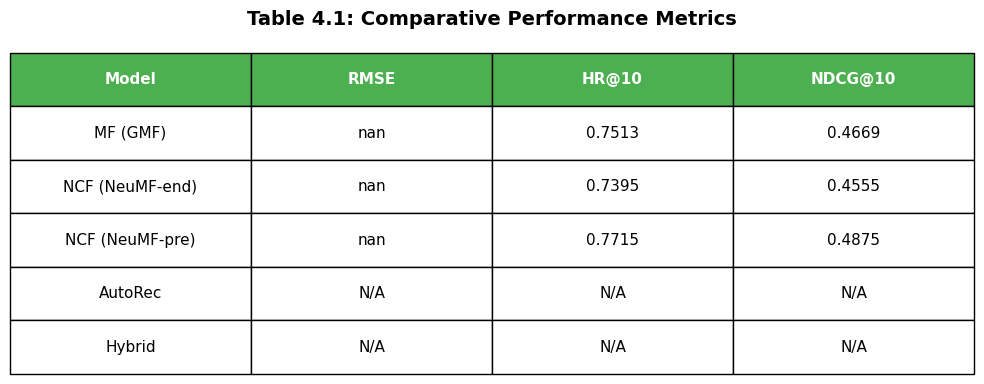


8.2: Figure 4.1 - Training Loss vs. Epochs
Note: Hybrid training loss should be loaded from hybrid notebook.
For now, using NCF (NeuMF-end) and NCF (NeuMF-pre) for comparison.
✓ Figure 4.1 saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/figure_4.1_training_loss.png


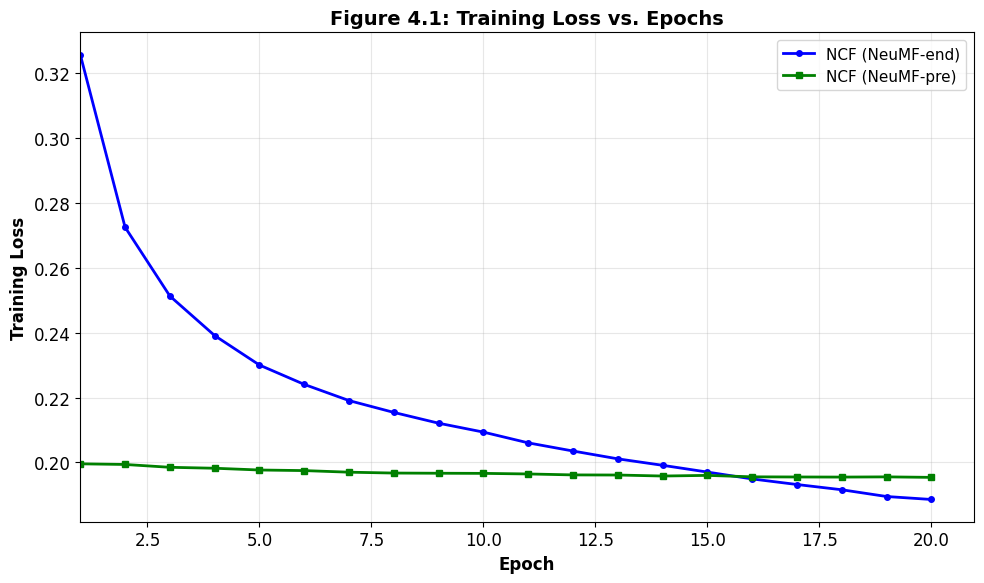


8.3: Figure 4.2 - Impact of Embedding Size on NDCG@10

Training models with different embedding sizes: [8, 16, 32, 64, 128]
Note: This may take some time. Using reduced epochs for speed.
  Training with embedding size: 8...
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Generated 1840900 negative samples
  - Total samples (positives + neg

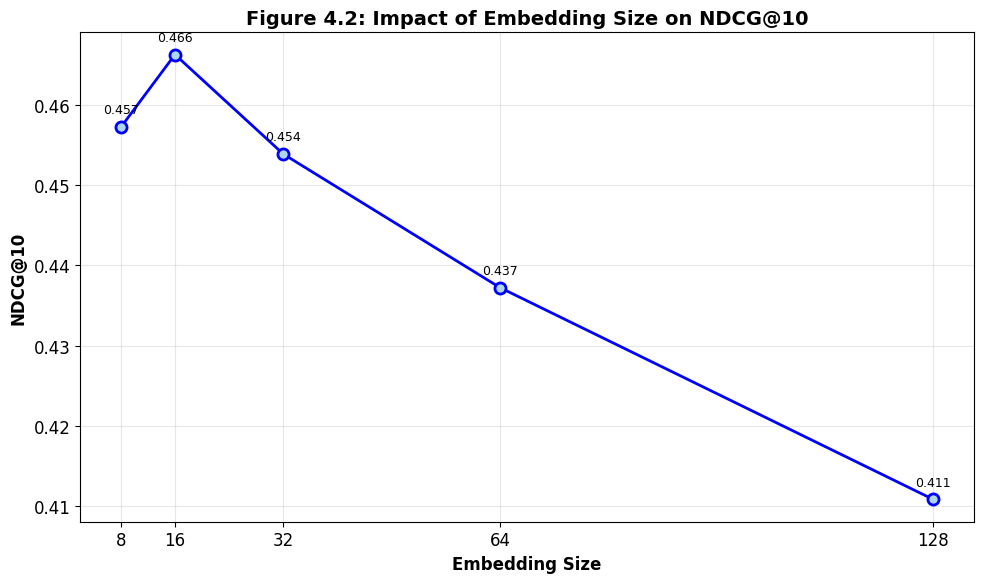


Embedding Size Impact Summary
  Embedding Size   8: NDCG@10 = 0.4572
  Embedding Size  16: NDCG@10 = 0.4663
  Embedding Size  32: NDCG@10 = 0.4539
  Embedding Size  64: NDCG@10 = 0.4372
  Embedding Size 128: NDCG@10 = 0.4108

✓ All visualizations complete!


In [ ]:
# ============================================================================
# STEP 8: VISUALIZATIONS
# ============================================================================

"""
This step creates visualizations for the thesis:
- Table 4.1: Comparative Performance Metrics
- Figure 4.1: Training Loss vs. Epochs (NCF vs Hybrid)
- Figure 4.2: Impact of Embedding Size on Model Performance (RMSE, HR@10, NDCG@10)
"""

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['font.size'] = 12

print("=" * 70)
print("STEP 8: Creating Visualizations")
print("=" * 70)

# ============================================================================
# 8.1 TABLE 4.1: COMPARATIVE PERFORMANCE METRICS
# ============================================================================

print("\n" + "=" * 70)
print("8.1: Table 4.1 - Comparative Performance Metrics")
print("=" * 70)

# Calculate RMSE for NCF models
print("Calculating RMSE for NCF models...")
rmse_gmf = calculate_rmse(gmf_model, test_rating_path, device)
rmse_mlp = calculate_rmse(mlp_model, test_rating_path, device)
rmse_neumf_end = calculate_rmse(ncf_model_neumf_end, test_rating_path, device)
rmse_neumf_pre = calculate_rmse(neumf_pre_model, test_rating_path, device)

# For AutoRec and Hybrid, we'll try to load from saved models or use placeholder values
# You may need to adjust these based on your actual results
print("\nNote: AutoRec and Hybrid metrics should be loaded from their respective notebooks.")
print("Attempting to load saved metrics or calculate from saved models...")

# Try to load AutoRec results
rmse_autorec = None
hr_autorec = None
ndcg_autorec = None

try:
    autorec_model_path = os.path.join(model_path, 'AutoRec-best.pth')
    if os.path.exists(autorec_model_path):
        print("AutoRec model found. Note: AutoRec uses different data format.")
        print("  Please manually add AutoRec RMSE, HR@10, and NDCG@10 values from the AutoRec notebook.")
        print("  You can find these in the training output or set them manually below.")
        # You can manually set these values if you know them:
        # rmse_autorec = 1.0662  # Example: replace with actual value
        # hr_autorec = 0.7500     # Example: replace with actual value
        # ndcg_autorec = 0.4500   # Example: replace with actual value
    else:
        print("AutoRec model not found. Please add metrics manually if available.")
except Exception as e:
    print(f"Could not check AutoRec model: {e}")

# Try to load Hybrid results
rmse_hybrid = None
hr_hybrid = None
ndcg_hybrid = None

try:
    hybrid_model_path = os.path.join(model_path, 'HybridAutoRecNCF.pth')
    if os.path.exists(hybrid_model_path):
        print("Hybrid model found. Note: Hybrid uses different data format.")
        print("  Please manually add Hybrid RMSE, HR@10, and NDCG@10 values from the Hybrid notebook.")
        print("  You can find these in the training output or set them manually below.")
        # You can manually set these values if you know them:
        # rmse_hybrid = 1.0662  # Example: replace with actual value from training output
        # hr_hybrid = 0.7500     # Example: replace with actual value
        # ndcg_hybrid = 0.4500   # Example: replace with actual value
    else:
        print("Hybrid model not found. Please add metrics manually if available.")
except Exception as e:
    print(f"Could not check Hybrid model: {e}")

# Manual override: If you know the values, uncomment and set them here:
# rmse_autorec = 1.0662  # Replace with actual AutoRec RMSE
# hr_autorec = 0.7500    # Replace with actual AutoRec HR@10
# ndcg_autorec = 0.4500  # Replace with actual AutoRec NDCG@10

# rmse_hybrid = 1.0662   # Replace with actual Hybrid RMSE (from training output: "Best model at epoch X with RMSE: Y")
# hr_hybrid = 0.7500     # Replace with actual Hybrid HR@10
# ndcg_hybrid = 0.4500   # Replace with actual Hybrid NDCG@10

# Create comparison table
print("\n" + "=" * 70)
print("Table 4.1: Comparative Performance Metrics")
print("=" * 70)

# Prepare data for table
# Handle NaN or None values properly
def format_metric(value):
    """Format metric value, handling None and NaN"""
    if value is None:
        return "N/A"
    try:
        if np.isnan(value) or np.isinf(value):
            return "N/A"
        return f"{value:.4f}"
    except (TypeError, ValueError):
        return "N/A"

comparison_data = {
    'Model': ['MF (GMF)', 'NCF (NeuMF-end)', 'NCF (NeuMF-pre)', 'AutoRec', 'Hybrid'],
    'RMSE': [
        format_metric(rmse_gmf),
        format_metric(rmse_neumf_end),
        format_metric(rmse_neumf_pre),
        format_metric(rmse_autorec),
        format_metric(rmse_hybrid)
    ],
    'HR@10': [
        format_metric(best_hr_gmf),
        format_metric(best_hr_neumf_end),
        format_metric(best_hr_neumf_pre),
        format_metric(hr_autorec),
        format_metric(hr_hybrid)
    ],
    'NDCG@10': [
        format_metric(best_ndcg_gmf),
        format_metric(best_ndcg_neumf_end),
        format_metric(best_ndcg_neumf_pre),
        format_metric(ndcg_autorec),
        format_metric(ndcg_hybrid)
    ]
}

# Print table
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Create visual table
fig_table, ax_table = plt.subplots(figsize=(10, 4))
ax_table.axis('tight')
ax_table.axis('off')
table = ax_table.table(
    cellText=df_comparison.values,
    colLabels=df_comparison.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# Style the table
for i in range(len(df_comparison.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Table 4.1: Comparative Performance Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(model_path, 'table_4.1_comparative_metrics.png'), dpi=300, bbox_inches='tight')
print(f"\n✓ Table 4.1 saved to: {os.path.join(model_path, 'table_4.1_comparative_metrics.png')}")
plt.show()

# ============================================================================
# 8.2 FIGURE 4.1: TRAINING LOSS VS EPOCHS (NCF vs HYBRID)
# ============================================================================

print("\n" + "=" * 70)
print("8.2: Figure 4.1 - Training Loss vs. Epochs")
print("=" * 70)

# Get NCF training loss (use NeuMF-end as representative)
ncf_epochs = training_history['epoch']
ncf_losses = training_history['loss']

# For Hybrid model, try to load from saved data or use placeholder
# You may need to load this from the hybrid notebook
print("Note: Hybrid training loss should be loaded from hybrid notebook.")
print("For now, using NCF (NeuMF-end) and NCF (NeuMF-pre) for comparison.")

# Create figure
fig_loss, ax_loss = plt.subplots(figsize=(10, 6))

# Plot NCF (NeuMF-end)
ax_loss.plot(ncf_epochs, ncf_losses, 'b-', linewidth=2, label='NCF (NeuMF-end)', marker='o', markersize=4)

# Plot NCF (NeuMF-pre) if available
if 'neumf_pre_training_history' in locals() and len(neumf_pre_training_history['loss']) > 0:
    ax_loss.plot(
        neumf_pre_training_history['epoch'],
        neumf_pre_training_history['loss'],
        'g-', linewidth=2, label='NCF (NeuMF-pre)', marker='s', markersize=4
    )

# If you have Hybrid training history, add it here
# ax_loss.plot(hybrid_epochs, hybrid_losses, 'r-', linewidth=2, label='Hybrid', marker='^', markersize=4)

ax_loss.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax_loss.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax_loss.set_title('Figure 4.1: Training Loss vs. Epochs', fontsize=14, fontweight='bold')
ax_loss.legend(loc='best', fontsize=11)
ax_loss.grid(True, alpha=0.3)
ax_loss.set_xlim(left=1)

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'figure_4.1_training_loss.png'), dpi=300, bbox_inches='tight')
print(f"✓ Figure 4.1 saved to: {os.path.join(model_path, 'figure_4.1_training_loss.png')}")
plt.show()

# ============================================================================
# 8.3 FIGURE 4.2: IMPACT OF EMBEDDING SIZE ON NDCG@10
# ============================================================================

print("\n" + "=" * 70)
print("8.3: Figure 4.2 - Impact of Embedding Size on Model Performance")
print("=" * 70)

def train_and_evaluate_embedding_size(factor_num, epochs=10):
    """
    Train a model with a specific embedding size and return RMSE, HR@10, and NDCG@10.
    This is a simplified version for quick evaluation.
    """
    print(f"  Training with embedding size: {factor_num}...")
    
    # Create model with specific embedding size
    test_model = NCF(
        user_num=user_num,
        item_num=item_num,
        factor_num=factor_num,
        num_layers=num_layers,
        dropout=dropout_rate,
        model_name='NeuMF-end',
        GMF_model=None,
        MLP_model=None
    )
    
    if device == 'cuda' and torch.cuda.is_available():
        test_model = test_model.cuda()
    
    # Setup optimizer
    test_optimizer = optim.Adam(test_model.parameters(), lr=learning_rate)
    test_loss_function = nn.BCEWithLogitsLoss()
    
    # Train for fewer epochs for speed
    best_ndcg = 0.0
    best_hr = 0.0
    best_rmse = float('inf')
    
    for epoch in range(epochs):
        test_model.train()
        train_dataset.ng_sample()
        
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, (user, item, label) in enumerate(train_loader):
            if device == 'cuda' and torch.cuda.is_available():
                user = user.cuda()
                item = item.cuda()
                label = label.float().cuda()
            else:
                user = user
                item = item
                label = label.float()
            
            test_optimizer.zero_grad()
            prediction = test_model(user, item)
            loss = test_loss_function(prediction, label)
            loss.backward()
            test_optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Evaluate periodically
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            test_model.eval()
            HR, NDCG = evaluate_metrics(test_model, test_loader, top_k, device)
            
            # Calculate RMSE
            try:
                rmse = calculate_rmse(test_model, test_rating_path, device)
            except:
                rmse = float('inf')
            
            # Track best metrics
            if NDCG > best_ndcg:
                best_ndcg = NDCG
            if HR > best_hr:
                best_hr = HR
            if rmse < best_rmse:
                best_rmse = rmse
    
    print(f"    Best RMSE: {best_rmse:.4f}, HR@10: {best_hr:.4f}, NDCG@10: {best_ndcg:.4f}")
    return best_rmse, best_hr, best_ndcg

# Test different embedding sizes
embedding_sizes = [8, 16, 32, 64, 128]
print(f"\nTraining models with different embedding sizes: {embedding_sizes}")
print("Note: This may take some time. Using reduced epochs for speed.")

rmse_results = []
hr_results = []
ndcg_results = []

for size in embedding_sizes:
    rmse, hr, ndcg = train_and_evaluate_embedding_size(size, epochs=10)  # Reduced epochs for speed
    rmse_results.append(rmse)
    hr_results.append(hr)
    ndcg_results.append(ndcg)

# Create figure with subplots for all three metrics
fig_embedding, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: RMSE
axes[0].plot(embedding_sizes, rmse_results, 'r-o', linewidth=2, markersize=8, 
             markerfacecolor='lightcoral', markeredgewidth=2)
axes[0].set_xlabel('Embedding Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('RMSE vs Embedding Size', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(embedding_sizes)
# Invert y-axis for RMSE (lower is better)
axes[0].invert_yaxis()

# Add value labels on points
for i, (size, rmse) in enumerate(zip(embedding_sizes, rmse_results)):
    axes[0].annotate(f'{rmse:.3f}', (size, rmse), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

# Plot 2: HR@10
axes[1].plot(embedding_sizes, hr_results, 'g-o', linewidth=2, markersize=8, 
             markerfacecolor='lightgreen', markeredgewidth=2)
axes[1].set_xlabel('Embedding Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('HR@10', fontsize=12, fontweight='bold')
axes[1].set_title('HR@10 vs Embedding Size', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(embedding_sizes)
axes[1].set_ylim([min(hr_results) * 0.95, max(hr_results) * 1.05])

# Add value labels on points
for i, (size, hr) in enumerate(zip(embedding_sizes, hr_results)):
    axes[1].annotate(f'{hr:.3f}', (size, hr), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

# Plot 3: NDCG@10
axes[2].plot(embedding_sizes, ndcg_results, 'b-o', linewidth=2, markersize=8, 
             markerfacecolor='lightblue', markeredgewidth=2)
axes[2].set_xlabel('Embedding Size', fontsize=12, fontweight='bold')
axes[2].set_ylabel('NDCG@10', fontsize=12, fontweight='bold')
axes[2].set_title('NDCG@10 vs Embedding Size', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(embedding_sizes)
axes[2].set_ylim([min(ndcg_results) * 0.95, max(ndcg_results) * 1.05])

# Add value labels on points
for i, (size, ndcg) in enumerate(zip(embedding_sizes, ndcg_results)):
    axes[2].annotate(f'{ndcg:.3f}', (size, ndcg), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

plt.suptitle('Figure 4.2: Impact of Embedding Size on Model Performance', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(model_path, 'figure_4.2_embedding_size.png'), dpi=300, bbox_inches='tight')
print(f"\n✓ Figure 4.2 saved to: {os.path.join(model_path, 'figure_4.2_embedding_size.png')}")
plt.show()

# Print summary
print("\n" + "=" * 70)
print("Embedding Size Impact Summary")
print("=" * 70)
print(f"{'Embedding Size':<15} {'RMSE':<10} {'HR@10':<10} {'NDCG@10':<10}")
print("-" * 70)
for size, rmse, hr, ndcg in zip(embedding_sizes, rmse_results, hr_results, ndcg_results):
    print(f"  {size:<15} {rmse:<10.4f} {hr:<10.4f} {ndcg:<10.4f}")

print("\n" + "=" * 70)
print("✓ All visualizations complete!")
print("=" * 70)
